### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os, glob
import random
import tqdm
import dlib

import matplotlib.pyplot as plt
%matplotlib inline

Load video files

In [2]:
dark_path = './video/dark'
light_path = './video/light'
ok_path = './video/ok'

dark_vid_paths = glob.glob(dark_path+'/*.mp4')
light_vid_paths = glob.glob(light_path+'/*.mp4')
ok_vid_paths = glob.glob(ok_path+'/*.mp4')

print("Num dark: ", len(dark_vid_paths))
print("Num light:", len(light_vid_paths))
print("Num ok:   ", len(ok_vid_paths))
print("\nPath example:")
print(dark_vid_paths[0])

Num dark:  31
Num light: 24
Num ok:    88

Path example:
./video/dark/SbLOej9xiGEh6w2QgzMNoQ#Bn7MJy3B4EZyIgjWLQWttA#10.10.18_08_24_49--qNj37DxchEJpUgjWLQXFIA-.mp4


In [3]:
# func to extract frames from videos
def frames_from_vid(vid_paths, num_frames_from_one_vid=2):
    np.random.seed(42)
    frames = []
    # go through all video files
    for vid in tqdm.tqdm(vid_paths):
        cap = cv2.VideoCapture(vid)
        vid_frames = []
        # load all frames from one video
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv reads in BGR fromat
            vid_frames.append(frame)
        # randomly pick some frames
        random_frames_idxs = np.random.choice(len(vid_frames), num_frames_from_one_vid)
        for i, idx in enumerate(random_frames_idxs):
            rnd_frame = vid_frames[idx]
            # every other frame we flip in order to have different images (as they're almost the same)
            if (i+1) % 2 == 0:
                rnd_frame = np.fliplr(rnd_frame)
            frames.append(rnd_frame)
    return frames

Quick look at the video data shows that most files are 10 sec duration and recorded in 8 frames per second.

Videos came in different number per category. Therefore, in order to make more balanced dataset, I've decided to pick one frame from every `ok` video and two frames from every `light` and `dark` video. Furthermore, as almost all frames from the same video are similar, I've decided to horizontaly flip every other frame in order to make dataset more diverce.

In [5]:
dark_vid_frames = frames_from_vid(dark_vid_paths, num_frames_from_one_vid=2)
light_vid_paths = frames_from_vid(light_vid_paths, num_frames_from_one_vid=2)
ok_vid_paths = frames_from_vid(ok_vid_paths, num_frames_from_one_vid=1)

print("-"*100)
print("Num dark frames: ", len(dark_vid_frames))
print("Num light frames:", len(light_vid_paths))
print("Num ok frames:   ", len(ok_vid_paths))

100%|██████████| 88/88 [00:56<00:00,  1.18it/s]

----------------------------------------------------------------------------------------------------
Num dark frames:  62
Num light frames: 48
Num ok frames:    88


In [6]:
frames = dark_vid_frames + light_vid_paths + ok_vid_paths
labels = ['dark']*len(dark_vid_frames) + ['light']*len(light_vid_paths) + ['ok']*len(ok_vid_paths)

print("Num frames:", len(frames))
print("Num labels:", len(labels))

Num frames: 198
Num labels: 198


### Example of a frame

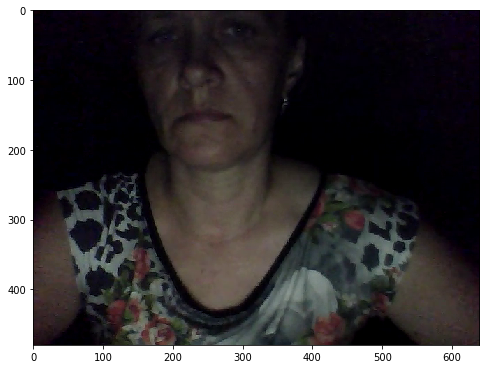

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(frames[random.randint(0, len(frames)-1)]);

I've used dlib's CNN face detector in order to locate faces in frames.

In [8]:
# will save data to pandas dataframe
df = pd.DataFrame(columns=['filename', 'label'])
save_path = './data'

# face detector
weights = './mmod_human_face_detector.dat'
cnn_face_detector = dlib.cnn_face_detection_model_v1(weights)

# detect faces and save data
faces = []
count = 0
for frame, label in zip(frames, labels):
    # initialize face detector
    faces_cnn = cnn_face_detector(frame, 1)
    
    # loop over detected faces
    for i, face in enumerate(faces_cnn):
        x = face.rect.left()
        y = face.rect.top()
        w = face.rect.right() - x
        h = face.rect.bottom() - y
        
        # select face from image
        face_img = frame[y:(y+h), x:(x+w)]
        
        # avoid errors
        if np.asarray(face_img).shape[0] == 0 or np.asarray(face_img).shape[1] == 0:
            continue
        
        faces.append(face_img)
        im_path = os.path.join(save_path, '{}.jpg'.format(count))
        
        try:
            cv2.imwrite(im_path, face_img)
            df.loc[len(df)] = {'filename': im_path, 'label': label}
        except:
            print("err in ", count)
    count += 1

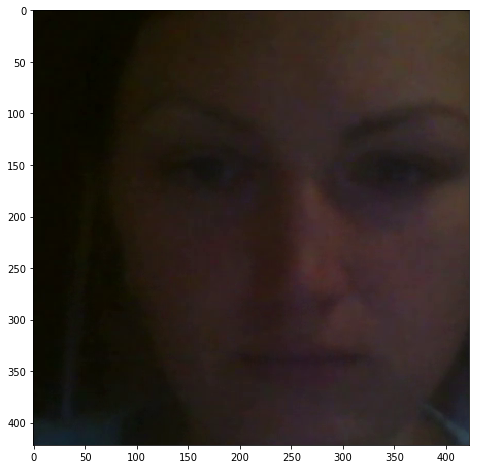

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(faces[random.randint(0, len(faces)-1)]);

In [10]:
# show example
df.sample(5)

,filename,label
92,./data/109.jpg,light
93,./data/110.jpg,ok
179,./data/195.jpg,ok
124,./data/140.jpg,ok
48,./data/65.jpg,light


In [11]:
# save data
df.to_csv('data.csv', index=False)

### Split Data

In [14]:
dataset = pd.read_csv('data.csv')
print(dataset.info())
print("-"*50)
print(dataset.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
filename    182 non-null object
label       182 non-null object
dtypes: object(2)
memory usage: 2.9+ KB
None
--------------------------------------------------
           filename label
172  ./data/188.jpg    ok
25    ./data/34.jpg  dark
141  ./data/157.jpg    ok
132  ./data/148.jpg    ok
38    ./data/49.jpg  dark


In [15]:
# this is how I will encode/decode labels
classes_list = list(dataset.label.value_counts().index)
print(classes_list)

classes = {x:i for i, x in enumerate(classes_list)}
to_class = {i:x for i, x in enumerate(classes_list)}
classes

['ok', 'light', 'dark']


{'ok': 0, 'light': 1, 'dark': 2}

In [17]:
# split
np.random.seed(42)
msk = np.random.rand(len(dataset)) < 0.9

train = dataset[msk]
valid = dataset[~msk]
print(len(train), len(valid))

# save
train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)

165 17


In [20]:
# save encoder/decoder
import pickle


tmp = {'classes': classes, 'to_class': to_class}
with open('encoder_decoder.pkl', 'wb') as f:
    pickle.dump(tmp, f)

In [21]:
# check
with open('encoder_decoder.pkl', 'rb') as f:
    encode_decode_labels = pickle.load(f)
classes = encode_decode_labels['classes']
to_class = encode_decode_labels['to_class']
to_class

{0: 'ok', 1: 'light', 2: 'dark'}